In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy as sy
from scipy.integrate import odeint

Physical fixed points: [[ 0.         -0.57735027]
 [ 0.          0.57735027]
 [ 2.          0.        ]]
Fixed points (0.0,-0.5773502691896257)
Eigen Values: [1.15470054 1.73205081]
Type=node
Stability=Repeller

Fixed points (0.0,0.5773502691896257)
Eigen Values: [-1.15470054 -1.73205081]
Type=node
Stability=Attractor

Fixed points (2.0,0.0)
Eigen Values: [ 1. -1.]
Type=node
Stability=saddle

[[ 0.         -0.57735027]
 [ 0.          0.57735027]
 [ 2.          0.        ]] [[ 6.          0.57735027]
 [ 6.         -0.57735027]]


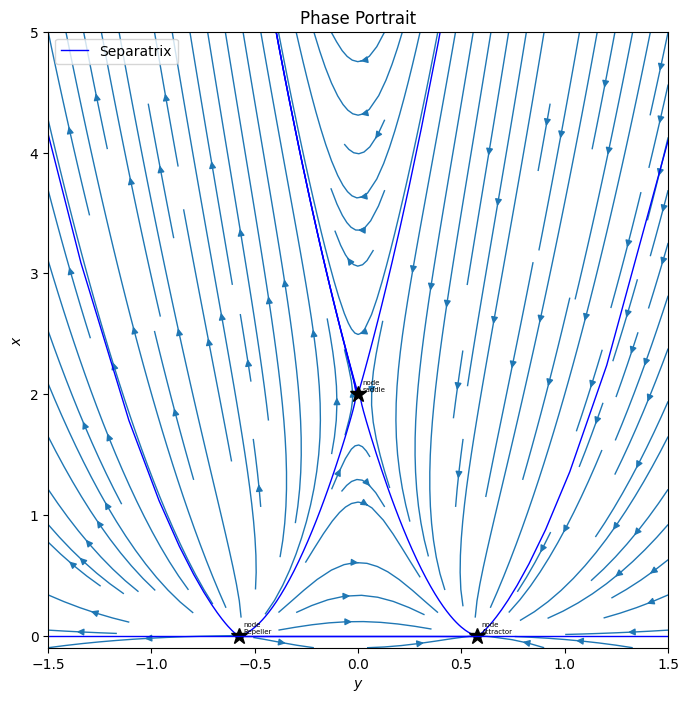

In [59]:
G= 6.67e-11
def dynamicsStateSpace(x,y):
  dx = -3*y*x
  dy = -y**2 -x/6 +1/3 
  return [dx,dy]

def dynamics_odeint(X,N):
  x,y = X
  if x > 6 or y < -1.5 or y > 1.5:
        return [0, 0]
  dx,dy = dynamicsStateSpace(x,y)
  return [dx,dy]


#  FP are [0,(np.sqrt(3)/3)]  [0,-(np.sqrt(3)/3)]  [2,0]  [6,(np.sqrt(3)/3)]  [6,-(np.sqrt(3)/3)]
ICs = [[0.00275,-(np.sqrt(3)/3)+0.01], #2-3
      [0.015,-(np.sqrt(3)/3)-0.015], #2-5
      #[0,-(np.sqrt(3)/3)-0.01], #2-left
      [0,-(np.sqrt(3)/3)+0.01], #2-1
      [2+0.01,-0.01], #3-5
      [2-0.01,+0.01], #3-1
      [6-0.002,(np.sqrt(3)/3)-0.07432], #4-3
      [4.1,1.4999],#4-1
      ]
simulationTime=np.linspace(0,30,200)




# Phase space range (similar to your -0.99 to 0.99 compact range)
x_vals_grid = np.linspace(-0.1, 5, 40)
y_vals_grid = np.linspace(-1.5, 1.5, 40)

X, Y = np.meshgrid(x_vals_grid, y_vals_grid)

dX = np.zeros(X.shape)
dY = np.zeros(Y.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        dX[i, j], dY[i, j] = dynamicsStateSpace(X[i, j], Y[i, j])


x_FP,y_FP = sp.symbols('x y', real=True)

f= -3*y_FP*x_FP
g= -y_FP**2 -x_FP/6 +1/3

J_sym = sp.Matrix([f, g]).jacobian([x_FP, y_FP]) # Symbolic Jacobian

solutions = sp.solve([f, g], [x_FP, y_FP], dict=True)
FP=[]
for sol in solutions:
  x_val = sol[x_FP]
  y_val = sol[y_FP]
  if x_val.is_real and y_val.is_real:
      FP.append([float(x_val.evalf()),float(y_val.evalf())])
FP=np.array(FP)
print("Physical fixed points:", FP)



plt.figure(figsize=(8,8))

plt.streamplot(y_vals_grid, x_vals_grid, dY.T, dX.T, 
               density=1.2,
               linewidth=1,
               arrowsize=1)

plt.xlabel(r"$y$")
plt.ylabel(r"$x$")
plt.title("Phase Portrait")
plt.xlim(-1.5, 1.5)
plt.ylim(-0.1, 5)


for ic in ICs:
  solutionState=odeint(dynamics_odeint,ic,simulationTime,rtol=1e-10,atol=1e-10,mxstep=500)


  #masking the solutions to x<=6
  mask = (solutionState[:,0]<=6) &  (solutionState[:,1] <=1.7) & (solutionState[:,1]>=-1.7)
  indecies = np.where(mask)[0] #      asked chatgpt "once my lines are reaching the edges, they are all plotting back to 0,0. how do i stop this"

  splits = np.where(np.diff(indecies)!=1)[0]+1
  contiguous_indecies = np.split(indecies,splits)


  for segment in contiguous_indecies:
    plt.plot(solutionState[segment, 1], solutionState[segment, 0], linewidth=1,color='b')




def classify_FP(eigvals,temp=1e-10):
  Real = np.real(eigvals)
  Imag = np.imag(eigvals)
  if np.all(Real<-temp):
    stability = 'Attractor'
  elif np.all(Real>temp):
    stability = 'Repeller'
  elif np.any(Real<-temp) and np.any(Real > temp):
    stability = 'saddle'
  elif np.all(np.abs(Real) < temp):
    stability = 'Centre'
  else:
    stability = 'NaN'
  if np.any(np.abs(Imag)>temp):
    point_type = 'Spiral'
  else:
    point_type = 'node'

  return stability,point_type

for fp in FP:
  x_c, y_c = fp
  J_num = np.array(J_sym.subs({x_FP:x_c,y_FP:y_c}),dtype=float)
  eigvals = np.linalg.eigvals(J_num)
  stability,point_type = classify_FP(eigvals)
  print(f'Fixed points ({x_c:},{y_c})')
  print('Eigen Values:',eigvals)
  print(f'Type={point_type}')
  print(f'Stability={stability}\n')
  plt.plot(y_c, x_c, 'k*', markersize=12)
  plt.text(y_c+0.02, x_c+0.02, f"{point_type}\n{stability}", fontsize=5)

# adding FPs at infinity
inf_FP = np.array([[6,np.sqrt(3)/3],[6,-np.sqrt(3)/3]])
plt.plot(inf_FP[:,1],inf_FP[:,0],'k*')
print(FP ,inf_FP)

y2 = np.linspace(-2,2,100)
x2 = np.zeros_like(y2)

plt.plot(y2,x2,color='b',linewidth=1,label='Separatrix')


plt.legend()
plt.show()



# https://aleksandarhaber.com/phase-portraits-of-state-space-models-and-differential-equations-in-python/
